# <center>The Battle of Neighborhoods - Chennai, India</center>

## <center>Applied Data Science Capstone Project by IBM on Coursera</center>

## Table of contents
1. [Introduction: Business Problem](#intro)
2. [Data Requirements](#data)
3. [Methodology](#methodology)
4. [Analysis](#analysis)
5. [Results](#results)
6. [Discussion](#discussion)
7. [Conclusion](#conclusion)

## Introduction: Business Problem <a name="intro"></a>

This project deals with discussing the neighborhoods of **Chennai, The Shipping hub of India**. This project would specifically help Business people planning to start **Restaurants, Hotels, etc.** in Chennai previously known as Madras, Tamil Nadu, India.

The **Foursquare API** is used to access the venues in the neighborhoods. Since, it returns less venues in the neighborhoods, we would be analysing areas for which countable number of venues are obtained. Then they are clustered based on their venues using Data Science Techniques. Here the **k-means clustering algorithm** is used to achieve the task. The optimal number of clusters can be obtained using **silhouette score**. **Folium visualization library** can be used to visualize the clusters superimposed on the map of Chennai city. These clusters can be analyzed to help small scale business owners select a suitable location for their need such as Hotels, Shopping Malls, Restaurants or even specifically Indian restaurants or Coffee shops.

#### Importing the required libraries

In [9]:
! pip install geopy
! pip install geocoder
import re
import json
import requests
import numpy as np
from bs4 import BeautifulSoup

import pandas as pd
#display all rows
pd.set_option('display.max_rows', None)
#display all columns
pd.set_option('display.max_columns', None)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from geopy.geocoders import Nominatim

import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

print('Libraries are imported.')

Libraries are imported.


## Data Requirements <a name="data"></a>

Chennai has multiple neighborhoods. Lets use the following dataset which has the list of locations in chennai along with their Latitude and Longitude:

https://chennaiiq.com/chennai/latitude_longitude_areas.asp

But the Latitude and Longitude data provided here is in Degrees Minute Seconds format. Thus before starting the analysis, the location data has to be converted to Decimal Degrees. First,. lets access the html file.

In [10]:
url = 'https://chennaiiq.com/chennai/latitude_longitude_areas.asp'

html = requests.get(url)
print(html)

<Response [200]>


A Reponse value of 200 means that the process was successful. Now we need to clean the file to access the Neighborhoods and their Locations. Lets use BeautifulSoup library to parse the html file in order to make it easier to access. 

In [11]:
soup = BeautifulSoup(html.text, 'html.parser')
table = soup.find("table", attrs={"class": "TBox"})

The html has been parsed and it can be used to build the dataset. Let us access the Location data and store it in a pandas dataframe, chennai_data.

#### Data Collection:

In [12]:
table_data = []
index = ['S.No.', 'Location', 'Latitude', 'Longitude']
for tr in table.find_all("tr", attrs={"class": "tab"}):
    t_row = {}
    for td, th in zip(tr.find_all("td"), index): 
        t_row[th] = td.text.replace('\n', '').strip()
    table_data.append(t_row)

chennai_data = pd.DataFrame(table_data[:-1], columns=index)
chennai_data.drop(columns=['S.No.'], inplace=True)
chennai_data.at[0,'Location'] = 'Adyar Bus Depot'
chennai_data.rename(columns={'Location': 'Neighborhood'}, inplace=True)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Depot,"12°59'50"" N","80°15'25"" E"
1,Adyar Signal,"13°00'23"" N","80°15'27"" E"
2,Alandur,"13°00'28"" N","80°12'35"" E"
3,Ambattur,"13°06'36"" N","80°10'12"" E"
4,Anna Arch,"13°04'28"" N","80°13'06"" E"


#### Convert Degrees Minute Seconds to Decimal Degrees

There are a total of 105 neighborhoods. But as said earlier the Latitude and Longitude data needs to be converted Degrees Minute Seconds to Decimal Degrees. The dms2dd fucntion defined below will solve this problem.

In [13]:
def dms2dd(s):
    degrees, minutes, seconds, direction = re.split('[°\'"]+', s)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction in ('S','W'):
        dd*= -1
    return dd

chennai_data['Latitude'] = chennai_data['Latitude'].apply(dms2dd)
chennai_data['Longitude'] = chennai_data['Longitude'].apply(dms2dd)
print(chennai_data.shape)
chennai_data.head()

(105, 3)


,Neighborhood,Latitude,Longitude
0,Adyar Bus Depot,12.997222,80.256944
1,Adyar Signal,13.006389,80.257500
2,Alandur,13.007778,80.209722
3,Ambattur,13.110000,80.170000
4,Anna Arch,13.074444,80.218333


Now that we have the neighborhoods dataset lets visualize them using Folium Library. First lets create a map of Chennai. The latitude and longitude of chennai can be obtained using the Geolocator library.

In [14]:
address = 'Chennai, Tamil Nadu'

geolocator = Nominatim(user_agent="chennai_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of chennai are {}, {}.'.format(latitude, longitude))

The geographical coordinate of chennai are 13.0836939, 80.270186.


#### Chennai Map:

In [15]:
# create map of Toronto using latitude and longitude values
chennai_map = folium.Map(location=[latitude, longitude], zoom_start=11)    
chennai_map

#### Chennai Map with the neighborhoods superimposed on top:

In [16]:
# add neighborhood markers to map
for lat, lng, location in zip(chennai_data['Latitude'], chennai_data['Longitude'], chennai_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chennai_map)  

chennai_map

#### Define Foursquare Credentials and Version

In [20]:
CLIENT_ID = 'QNWZDRGOQIZM0MWGMJDSNFJDJZH0BWEPYJQAIRYOMB0BACKC' # your Foursquare ID
CLIENT_SECRET = '0X2I05JL2XWV4H1L5FWZT1O3NYSDVVADVJEMZVPJ3DFWR13I' # your Foursquare Secret
ACCESS_TOKEN = 'LVUGKMKLJKHESNJHSCQ1HS5AH23NEGNV44ZY2YAHIATRM3UL' # your FourSquare Access Token
VERSION = '20180604'

#### Explore neighborhoods in Chennai

The following function will send a explore request for each neighborhood and return the 100 most popular places in the neighborhood around 500 meters.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        count = 1
        while count != 5:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                count = 5
            except:
                count += 1
    
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Lets use the above function on the chennai_data neighborhoods dataframe and store the venues data returned in the chennai_venues pandas dataframe.

In [22]:
chennai_venues = getNearbyVenues(names = chennai_data['Neighborhood'],
                                 latitudes = chennai_data['Latitude'],
                                 longitudes = chennai_data['Longitude']
                                 )

print(chennai_venues.shape)
chennai_venues.head()

(1022, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Depot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Depot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
2,Adyar Bus Depot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
3,Adyar Bus Depot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Depot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place


A total of 1022 venues were obtained. Now lets check the number of venues returned per neighborhood.

In [30]:
chennai_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
AVM Studio,5,5,5,5,5,5
Adyar Bus Depot,13,13,13,13,13,13
Adyar Signal,23,23,23,23,23,23
Alandur,12,12,12,12,12,12
Ambattur,1,1,1,1,1,1
Anna Arch,12,12,12,12,12,12
Anna Nagar Roundana,20,20,20,20,20,20
Anna Nagar West Terminus,6,6,6,6,6,6
Anna Statue,9,9,9,9,9,9


From the above dataframe we can see that Taj Coromandal returned the highest number of venues i.e. 42. Now lets check the unique categories of all the venues returned.

In [31]:
print('There are {} uniques categories.'.format(len(chennai_venues['Venue Category'].unique())))

There are 137 uniques categories.


## Methodology <a name="methodology"></a>

Now, we have the neighborhoods data of chennai (**105 neighborhoods**). We also have the most popular venues in each neighborhood obtained using Foursquare API. A total of **1130 venues** have been obtained in the whole city and **145 unique categories**. But as seen we have multiple neighborhoods with less than 10 venues returned. In order to create a good analysis let's consider only the **_neighborhoods with more than 10 venues_**.

We can perform one hot encoding on the obtained data set and use it find the **10 most common venue category** in each neighborhood. Then clustering can be performed on the dataset. Here **K - Nearest Neighbor** clustering technique have been used. To find the optimal number of clusters **silhouette score** metric technique is used.

The clusters obtained can be analyzed to find the major type of venue categories in each cluster. This data can be used to suggest business people, suitable locations based on the category.

## Analysis <a name="analysis"></a>

First, lets visualize the number of venues obtained in all the neighborhoods of Chennai.

<AxesSubplot:xlabel='Neighborhood'>

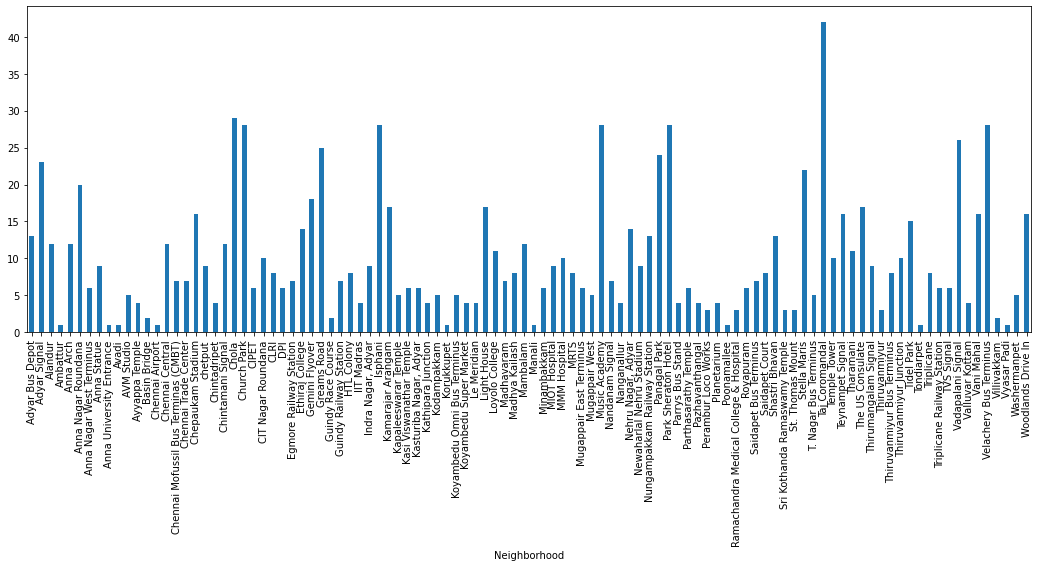

In [32]:
df = chennai_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

As we can see from the above bar chart, there are many neighborhoods with less than 10 venues which can be remove before performing the analysis to obtain better results. The following plot shows only the neighborhoods from which 10 or more than 10 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

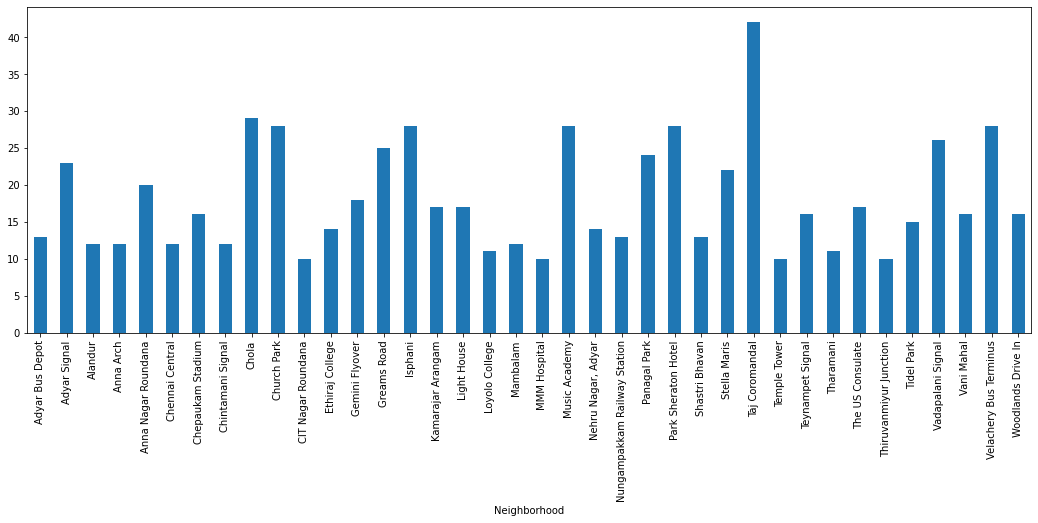

In [33]:
df = df[df >= 10]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, **chennai_venues_top** that contains only the neighborhoods with 10+ venues and the venues with their details included.

In [34]:
chennai_venues_top = chennai_venues[chennai_venues['Neighborhood'].isin(df.index.tolist())]
chennai_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adyar Bus Depot,12.997222,80.256944,Zaitoon Restaurant,12.996861,80.256178,Middle Eastern Restaurant
1,Adyar Bus Depot,12.997222,80.256944,Zha Cafe,12.999730,80.254806,Café
2,Adyar Bus Depot,12.997222,80.256944,Kuttanadu Restaurant,12.997010,80.257799,Asian Restaurant
3,Adyar Bus Depot,12.997222,80.256944,Barbeque N Biryani,12.995907,80.256011,BBQ Joint
4,Adyar Bus Depot,12.997222,80.256944,Domino's Pizza,13.001470,80.256626,Pizza Place


#### One hot encoding

In [35]:
chennai_onehot = pd.get_dummies(chennai_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chennai_onehot['Neighborhood'] = chennai_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = chennai_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
chennai_onehot = chennai_onehot.reindex(columns = fixed_columns)

print(chennai_onehot.shape)
chennai_onehot.head()

(688, 102)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bistro,Bookstore,Boutique,Breakfast Spot,Bus Line,Bus Station,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Food,Food Court,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,General Entertainment,Gourmet Shop,Grocery Store,Health Food Store,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Playground,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Tea Room,Thai Restaurant,Theater,Track,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Adyar Bus Depot,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Adyar Bus Depot,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [36]:
chennai_grouped = chennai_onehot.groupby('Neighborhood').mean().reset_index()
print(chennai_grouped.shape)
chennai_grouped.head()

(38, 102)


,Neighborhood,ATM,Accessories Store,African Restaurant,Airport,American Restaurant,Amphitheater,Art Gallery,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Beach,Bistro,Bookstore,Boutique,Breakfast Spot,Bus Line,Bus Station,Business Service,Café,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Department Store,Dessert Shop,Donut Shop,Eastern European Restaurant,Electronics Store,Fast Food Restaurant,Food,Food Court,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,General Entertainment,Gourmet Shop,Grocery Store,Health Food Store,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kerala Restaurant,Liquor Store,Lounge,Market,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Store,Nightclub,North Indian Restaurant,Office,Paper / Office Supplies Store,Park,Pizza Place,Platform,Playground,Pub,Ramen Restaurant,Recreation Center,Restaurant,Rock Club,Russian Restaurant,Salon / Barbershop,Sandwich Place,Sculpture Garden,Shoe Store,Shopping Mall,Snack Place,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Steakhouse,Tea Room,Thai Restaurant,Theater,Track,Train,Train Station,Vegetarian / Vegan Restaurant,Women's Store
0,Adyar Bus Depot,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.153846,0.0,0.076923,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.076923,0.000000,0.076923,0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.076923,0.000000,0.000000,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.153846,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.076923,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
1,Adyar Signal,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.000000,0.043478,0.0,0.000000,0.0,0.0,0.043478,0.0,0.000000,0.000000,0.000000,0.0,0.043478,0.0,0.0,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.043478,0.0,0.0,0.043478,0.043478,0.000000,0.000000,0.000000,0.043478,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.347826,0.0,0.0,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.086957,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478,0.0,0.0,0.000000,0.0,0.043478,0.0,0.043478,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
2,Alandur,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.000000,0.0,0.000000,0.083333,0.166667,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.083333,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.083333,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.00,0.0
3,Anna Arch,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.0,0.000000,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.083333,0.166667,0.083333,0.083333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.083333,0.0,0.0,0.000000,0.0,0.00,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0
4,Anna Nagar Roundana,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.050000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.050000,0.0,0.000000,0.000000

The following function returns the top_venues of each neighborhood.

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe **neighborhoods_venues_sorted**.

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create column names according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chennai_grouped['Neighborhood']

for ind in np.arange(chennai_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chennai_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Depot,Indian Restaurant,Asian Restaurant,BBQ Joint,Pizza Place,Café,Bus Station,Breakfast Spot,Middle Eastern Restaurant,Sandwich Place,Fruit & Vegetable Store
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Bakery,Café,Dessert Shop,Rock Club,Bookstore,Electronics Store,Fast Food Restaurant,Coffee Shop
2,Alandur,Bus Station,Hotel,South Indian Restaurant,Hotel Bar,Bus Line,Restaurant,Metro Station,Bar,Indian Restaurant,Train
3,Anna Arch,Clothing Store,Fast Food Restaurant,Sporting Goods Shop,Café,Multiplex,Bookstore,Food,Food Court,Electronics Store,Pizza Place
4,Anna Nagar Roundana,Indian Restaurant,Clothing Store,Shoe Store,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Paper / Office Supplies Store


#### Cluster Neighborhoods

Here k-Nearest Neighborhoods clustering technique is used. Lets use the **silhouette_score** to obtain the best value for the number of clusters.

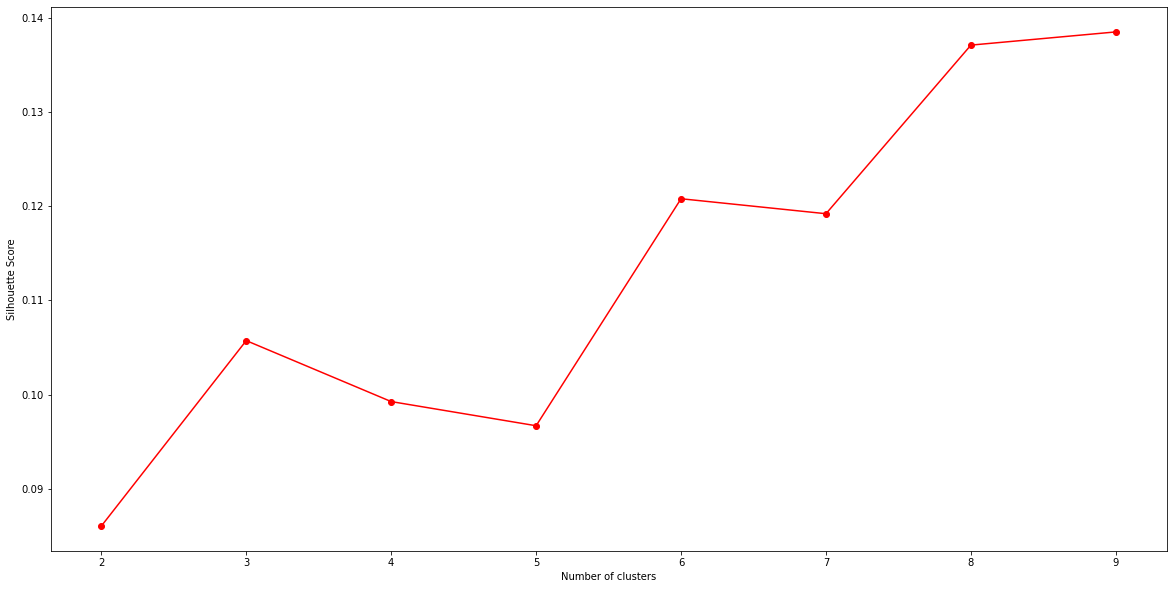

In [39]:
chennai_grouped_clustering = chennai_grouped.drop('Neighborhood', 1)

max_score = 10
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(chennai_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(chennai_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the highest silhouette score is 8. So, lets consider the number of clusters as 8.

In [40]:
# select best number of clusters
kclusters = 9

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(chennai_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 8, 1, 0, 4, 5, 0, 0, 2])

Add the cluster labels to the **neighborhoods_venues_sorted** dataframe. And lets create a new datframe **chennai_merged** which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

chennai_merged = chennai_venues_top[chennai_venues_top.columns[0:3]].drop_duplicates()
chennai_merged.reset_index(drop = True, inplace = True)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chennai_merged = chennai_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

chennai_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Depot,12.997222,80.256944,0,Indian Restaurant,Asian Restaurant,BBQ Joint,Pizza Place,Café,Bus Station,Breakfast Spot,Middle Eastern Restaurant,Sandwich Place,Fruit & Vegetable Store
1,Adyar Signal,13.006389,80.257500,0,Indian Restaurant,North Indian Restaurant,Bakery,Café,Dessert Shop,Rock Club,Bookstore,Electronics Store,Fast Food Restaurant,Coffee Shop
2,Alandur,13.007778,80.209722,8,Bus Station,Hotel,South Indian Restaurant,Hotel Bar,Bus Line,Restaurant,Metro Station,Bar,Indian Restaurant,Train
3,Anna Arch,13.074444,80.218333,1,Clothing Store,Fast Food Restaurant,Sporting Goods Shop,Café,Multiplex,Bookstore,Food,Food Court,Electronics Store,Pizza Place
4,Anna Nagar Roundana,13.084444,80.218056,0,Indian Restaurant,Clothing Store,Shoe Store,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Paper / Office Supplies Store


## Results <a name="results"></a>

Let’s examine the clusters and find the discriminating venue categories that distinguish each cluster. For this purpose lets also print the ten most common venue category in each cluster.

#### Cluster 1

In [42]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adyar Bus Depot,Indian Restaurant,Asian Restaurant,BBQ Joint,Pizza Place,Café,Bus Station,Breakfast Spot,Middle Eastern Restaurant,Sandwich Place,Fruit & Vegetable Store
1,Adyar Signal,Indian Restaurant,North Indian Restaurant,Bakery,Café,Dessert Shop,Rock Club,Bookstore,Electronics Store,Fast Food Restaurant,Coffee Shop
4,Anna Nagar Roundana,Indian Restaurant,Clothing Store,Shoe Store,Vegetarian / Vegan Restaurant,Juice Bar,Fast Food Restaurant,Electronics Store,Middle Eastern Restaurant,Coffee Shop,Paper / Office Supplies Store
6,Chepaukam Stadium,Indian Restaurant,Bookstore,Hotel,Music Store,General Entertainment,Café,Business Service,Mediterranean Restaurant,Bar,Breakfast Spot
7,Chintamani Signal,Indian Restaurant,Restaurant,Middle Eastern Restaurant,Accessories Store,Bakery,Coffee Shop,Electronics Store,Fast Food Restaurant,Concert Hall,Convenience Store
18,Mambalam,Clothing Store,Indian Restaurant,Jewelry Store,Concert Hall,Asian Restaurant,South Indian Restaurant,Boutique,Food,Convenience Store,Cosmetics Shop
23,Panagal Park,Indian Restaurant,Clothing Store,South Indian Restaurant,Jewelry Store,Vegetarian / Vegan Restaurant,Dessert Shop,Concert Hall,Coffee Shop,Pizza Place,Café
25,Shastri Bhavan,Indian Restaurant,Chinese Restaurant,Japanese Restaurant,Theater,Convenience Store,Asian Restaurant,Multicuisine Indian Restaurant,Coffee Shop,Fast Food Restaurant,Electronics Store
27,Taj Coromandal,Indian Restaurant,Chinese Restaurant,Café,Sandwich Place,Italian Restaurant,Asian Restaurant,Ice Cream Shop,Dessert Shop,Pizza Place,Hotel
34,Vadapalani Signal,Indian Restaurant,Shopping Mall,Fast Food Restaurant,Asian Restaurant,Multiplex,Clothing Store,South Indian Restaurant,Café,Italian Restaurant,Ice Cream Shop


In [43]:
cluster1 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 0, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Indian Restaurant            10
Café                          6
Coffee Shop                   5
Asian Restaurant              5
Fast Food Restaurant          5
Clothing Store                4
Electronics Store             4
Middle Eastern Restaurant     3
Convenience Store             3
Pizza Place                   3
dtype: int64


#### Cluster 2

In [44]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Anna Arch,Clothing Store,Fast Food Restaurant,Sporting Goods Shop,Café,Multiplex,Bookstore,Food,Food Court,Electronics Store,Pizza Place
16,Light House,Fast Food Restaurant,Coffee Shop,Bar,Department Store,Sandwich Place,Sculpture Garden,Snack Place,Athletics & Sports,Beach,Cosmetics Shop
17,Loyolo College,Women's Store,South Indian Restaurant,Vegetarian / Vegan Restaurant,Gourmet Shop,Fast Food Restaurant,Mexican Restaurant,Department Store,Ice Cream Shop,Chinese Restaurant,Café
22,Nungampakkam Railway Station,Department Store,Fast Food Restaurant,Women's Store,South Indian Restaurant,Asian Restaurant,Chinese Restaurant,Clothing Store,Ice Cream Shop,Vegetarian / Vegan Restaurant,Mexican Restaurant


In [45]:
cluster2 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 1, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Fast Food Restaurant             4
Department Store                 3
Chinese Restaurant               2
Clothing Store                   2
Café                             2
Women's Store                    2
Vegetarian / Vegan Restaurant    2
Ice Cream Shop                   2
South Indian Restaurant          2
Mexican Restaurant               2
dtype: int64


#### Cluster 3

In [46]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Chola,Indian Restaurant,Hotel,Restaurant,Italian Restaurant,Bar,Ice Cream Shop,Vegetarian / Vegan Restaurant,Juice Bar,Kerala Restaurant,Lounge
11,Ethiraj College,Hotel,Kebab Restaurant,Bar,Indian Restaurant,Juice Bar,Fast Food Restaurant,Donut Shop,Pizza Place,Restaurant,ATM
12,Gemini Flyover,Hotel,Nightclub,Coffee Shop,Sandwich Place,South Indian Restaurant,Park,Chinese Restaurant,Café,Concert Hall,Pizza Place
14,Isphani,Indian Restaurant,Hotel,South Indian Restaurant,Coffee Shop,Nightclub,Chinese Restaurant,Sandwich Place,Pizza Place,Lounge,Bar
15,Kamarajar Arangam,Café,Hotel,Nightclub,Indian Restaurant,Ice Cream Shop,South Indian Restaurant,Concert Hall,Amphitheater,Pizza Place,Park
20,Music Academy,Indian Restaurant,Hotel,Café,Restaurant,Women's Store,Russian Restaurant,African Restaurant,Bank,Bar,Chinese Restaurant
24,Park Sheraton Hotel,Indian Restaurant,Café,Italian Restaurant,Hotel,Thai Restaurant,Coffee Shop,Restaurant,Sandwich Place,Japanese Restaurant,Dessert Shop
26,Stella Maris,Indian Restaurant,Hotel,Juice Bar,Women's Store,Sandwich Place,African Restaurant,Bakery,Bar,Chinese Restaurant,Fast Food Restaurant
29,Teynampet Signal,Hotel,Pub,Indian Restaurant,Lounge,Pizza Place,Italian Restaurant,Clothing Store,Juice Bar,Café,Food
31,The US Consulate,Hotel,Nightclub,Coffee Shop,Sandwich Place,South Indian Restaurant,Park,Café,Bar,Chinese Restaurant,Indian Restaurant


In [47]:
cluster3 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 2, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Hotel                      12
Indian Restaurant          11
Bar                         8
Café                        6
Coffee Shop                 6
Chinese Restaurant          6
Sandwich Place              5
South Indian Restaurant     5
Pizza Place                 5
Nightclub                   5
dtype: int64


#### Cluster 4

In [48]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Church Park,Indian Restaurant,Multiplex,Chinese Restaurant,Hotel,Movie Theater,Park,Fast Food Restaurant,Café,Pub,Nightclub
13,Greams Road,Multiplex,Café,Indian Restaurant,Juice Bar,Movie Theater,Chinese Restaurant,Middle Eastern Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Kebab Restaurant
19,MMM Hospital,Department Store,Indian Restaurant,Middle Eastern Restaurant,Health Food Store,Juice Bar,Convenience Store,Fruit & Vegetable Store,Bakery,Pizza Place,Comfort Food Restaurant
32,Thiruvanmiyur Junction,Multiplex,Indian Restaurant,Hotel,Paper / Office Supplies Store,Clothing Store,Chinese Restaurant,Pizza Place,Japanese Restaurant,General Entertainment,Department Store
36,Velachery Bus Terminus,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,Pizza Place,Restaurant,Snack Place,Multiplex,Ramen Restaurant,Department Store,Men's Store


In [49]:
cluster4 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 3, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Indian Restaurant            5
Multiplex                    4
Chinese Restaurant           4
Department Store             3
Pizza Place                  3
Fast Food Restaurant         2
Hotel                        2
Middle Eastern Restaurant    2
Juice Bar                    2
Movie Theater                2
dtype: int64


#### Cluster 5

In [50]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,CIT Nagar Roundana,Italian Restaurant,Art Gallery,Ice Cream Shop,Pub,Department Store,Cocktail Bar,South Indian Restaurant,Bar,Hotel,Grocery Store
28,Temple Tower,Hotel,Sports Bar,Playground,Pub,Department Store,Bar,South Indian Restaurant,Cocktail Bar,Grocery Store,Art Gallery


In [51]:
cluster5 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 4, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

print(venues5.value_counts().head(10))

Pub                        2
Hotel                      2
Bar                        2
Grocery Store              2
Cocktail Bar               2
Art Gallery                2
Department Store           2
South Indian Restaurant    2
Playground                 1
Ice Cream Shop             1
dtype: int64


#### Cluster 6

In [52]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Chennai Central,Train Station,Indian Restaurant,Bookstore,Hotel,Vegetarian / Vegan Restaurant,Nightclub,Bus Station,Sandwich Place,Eastern European Restaurant,Concert Hall


In [53]:
cluster6 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 5, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

print(venues6.value_counts().head(10))

Concert Hall                     1
Bookstore                        1
Bus Station                      1
Vegetarian / Vegan Restaurant    1
Nightclub                        1
Hotel                            1
Train Station                    1
Sandwich Place                   1
Indian Restaurant                1
Eastern European Restaurant      1
dtype: int64


#### Cluster 7

In [54]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Nehru Nagar, Adyar",Café,Indian Restaurant,Chinese Restaurant,Pizza Place,Ice Cream Shop,Department Store,Sandwich Place,Health Food Store,Grocery Store,Comfort Food Restaurant


In [55]:
cluster7 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 6, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

print(venues7.value_counts().head(10))

Ice Cream Shop             1
Health Food Store          1
Department Store           1
Chinese Restaurant         1
Sandwich Place             1
Pizza Place                1
Grocery Store              1
Café                       1
Indian Restaurant          1
Comfort Food Restaurant    1
dtype: int64


#### Cluster 8

In [56]:
chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + list(range(4, chennai_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Tharamani,Indian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Office,Chinese Restaurant,Café,Food Court,Sandwich Place,Hotel,Donut Shop
33,Tidel Park,Food Court,Fast Food Restaurant,Café,Sandwich Place,Juice Bar,Office,Platform,Indian Restaurant,Vegetarian / Vegan Restaurant,General Entertainment


In [57]:
cluster8 = chennai_merged.loc[chennai_merged['Cluster Labels'] == 7, chennai_merged.columns[[0] + 
                                                                                    list(range(4, chennai_merged.shape[1]))]]
venues8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

print(venues8.value_counts().head(10))

Fast Food Restaurant             2
Vegetarian / Vegan Restaurant    2
Sandwich Place                   2
Office                           2
Food Court                       2
Café                             2
Indian Restaurant                2
Donut Shop                       1
Chinese Restaurant               1
Platform                         1
dtype: int64


## Discussion <a name="discussion"></a>

Lets visulaize the top 5 most common venue categories in each of the cluster.

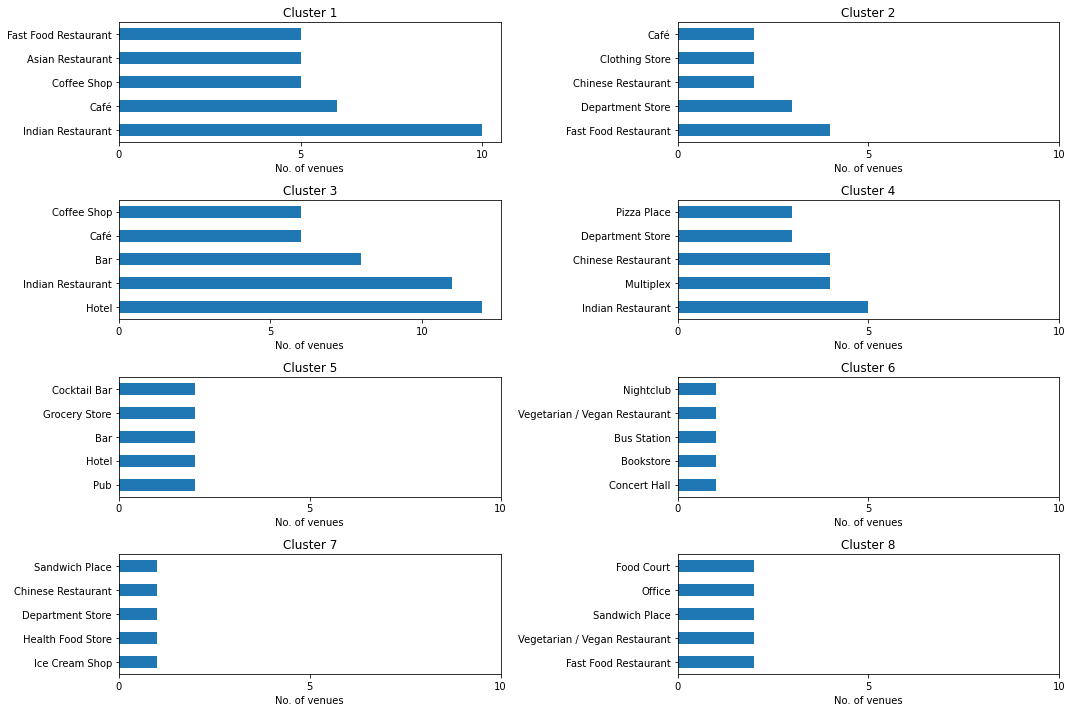

In [58]:
df_list = [venues1 ,venues2, venues3, venues4, venues5, venues6, venues7, venues8]
fig, axes = plt.subplots(4, 2)

count = 0
for r in range(4):
    for c in range(2):
        df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
        axes[r,c].set_title('Cluster {}'.format(count+1))
        plt.sca(axes[r, c])
        plt.xticks(np.arange(0, 15, 5))
        plt.xlabel('No. of venues')
        count += 1

fig.tight_layout()

This plot can be used to suggest valuable information to Business persons. Let's discuss a few examples considering they would like to start the following category of business.

#### 1. Hotel

The neighborhoods in cluster 2 has the greatest number of hotels, hence opening one here is not the best choice. So, is it best to open one at the neighborhoods in cluster 7 or 8? Not likely, since the place has a smaller number of food restaurants. Thus, an optimal place would be one which has less hotels, but also have restaurants and other places to explore. Considering all these facts, the best choice would be Cluster 3 and Cluster 4. such as the Adyar Bus Depot, Triplicane neighborhoods.

#### 2. Shopping Mall

The neighborhoods 5 has notable number of shopping malls. By using the same procedure as above, the suitable cluster would be the Cluster 2 and Cluster 3, since it has not much shopping malls and also it has many Hotels and Restaurants which gives an advantage.

Similarly, based on the requirement suggestions can be provided about the neighborhood that would be best suitable for the business.

#### Map of Chennai with the clusters superimposed on top

This map can be used to find a suitable location to start a new business based on the category.

In [59]:
# create map
chennai_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(chennai_merged['Neighborhood Latitude'], chennai_merged['Neighborhood Longitude'], chennai_merged['Neighborhood'], chennai_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(chennai_clusters_map)
       
chennai_clusters_map

This map can also be used to select a vast suggestion area for a particular type of business based on the category.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to analyze the neighborhoods of Chennai and create a clustering model to suggest personals places to start a new business based on the category. The neighborhoods data was obtained from an online source and the Foursquare API was used to find the major venues in each neighborhood. But we found that many neighborhoods had less than 10 venues returned. In order to build a good Data Science model, we filtered out these locations. The remaining locations were used to create a clustering model. The best number of clusters i.e. 8 was obtained using the silhouette score. Each cluster was examined to find the most venue categories present, that defines the characteristics for that particular cluster. 

A few examples for the applications that the clusters can be used for have also been discussed. A map showing the clusters have been provided. Both these can be used by stakeholders to decide the location for the particular type of business. A major drawback of this project was that the Foursquare API returned only few venues in each neighborhood. As a future improvement, better data sources can be used to obtain more venues in each neighborhood. This way the neighborhoods that were filtered out can be included in the clustering analysis to create a better decision model.